In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [3]:
DATA_PATH_ORIG = r'../data/capture20110812.pcap.netflow.labeled.csv'
DATA_PATH_NEW = r'../data/capture20110812.pcap.netflow.labeled_processed.csv'

## IMPORTANT     
The code below reads the file and erases the '->' characters.    
It takes quite a few minutes, so run it only if you don't have the processed file yet :(

In [4]:
# text = open(DATA_PATH, "r")
# text = ''.join([i for i in text]) \
#     .replace("->", "")
# x = open(DATA_PATH_NEW,"w")
# x.writelines(text)
# x.close()

Read the data

In [5]:
column_names = ['_', '_2', 'duration', 'protocol', 'src_addr', 'dst_addr', 'flags', 'tos', 'packets', 'bytes', 'flows', 'label']

df = pd.read_csv(
    DATA_PATH_NEW,
    delimiter='\s+',
    skiprows=[0],
    header=None, 
    names=column_names,
    index_col=False,
    parse_dates={"start_date": [0,1]}
)
df.head()

,start_date,duration,protocol,src_addr,dst_addr,flags,tos,packets,bytes,flows,label
0,2011-08-12 15:24:01.105,4.677,TCP,74.125.108.243:80,147.32.86.187:55707,PA_,0,452,682688,1,Background
1,2011-08-12 15:24:01.105,3.110,TCP,147.32.84.164:22,83.208.193.123:15173,PA_,0,5,506,1,LEGITIMATE
2,2011-08-12 15:24:01.105,4.678,TCP,147.32.86.187:55707,74.125.108.243:80,A_,0,106,6510,1,LEGITIMATE
3,2011-08-12 15:24:01.106,4.989,TCP,217.168.211.184:3953,147.32.84.14:22,PA_,0,1393,95812,1,Background
4,2011-08-12 15:24:01.113,4.988,UDP,173.9.132.155:54369,147.32.84.59:15046,INT,0,811,680898,1,Background


Have a look at the labels we have

In [6]:
df['label'].unique()

array(['Background', 'LEGITIMATE', 'Botnet'], dtype=object)

We obtained the IP of the infected host from the documentation of the scenario 44.

In [7]:
host_ip = "147.32.84.165" # IP obtained from documentation

Let's keep all the other IPs the host connects with

In [8]:
# let's build an iterable with all the other IPs this guy connects with
connections = df[(df['src_addr'] == host_ip) | (df['dst_addr'] == host_ip)][['src_addr', 'dst_addr']]

other_ips = connections.apply(lambda row: row['dst_addr'] if row['src_addr'] == host_ip else row['src_addr'], axis=1)
print(f"{other_ips.size} connections with the host found.")

3652 connections with the host found.


Just a sanity check to assert that we do not have our host_ip somewhere in the list of IPs

In [9]:
print(len([ip for ip in other_ips if ip != host_ip]))
print(len(other_ips))

3652
3652


# Reservoir
https://stackoverflow.com/questions/12732982/design-a-storage-algorithm/12733515#12733515     
https://stackoverflow.com/questions/2612648/reservoir-sampling       
http://web.archive.org/web/20141026071430/http://propersubset.com:80/2010/04/choosing-random-elements.html

In [10]:
def reservoir_sampling(stream, reservoir_size):
    stored_items = []
    for N, stream_item in enumerate(stream):
        if N < reservoir_size:
            # as long as we have space, the probability of storing is 100%
            stored_items.append(stream_item)
        else:
            # when N = i+1 we have i IPs stored (i > reservoir_size) 
            # In such a case, we want probability i/i+1 of storing the new IP, substituting one of the stored ones.        
            m = random.randint(0,N)
            if m < reservoir_size:
                stored_items[m] = stream_item
    return pd.Series(stored_items)

In [12]:
def compute_reservoir_error(original, sampled, n_of_ips, verbose=False):
    if verbose:
        print(f"Size of stream: {original.size}. Size of reservoir: {sampled.size}")
    
    original = original.value_counts().sort_values(ascending=False)
    sampled = sampled.value_counts().sort_values(ascending=False)
    
    top_n_to_find = original[:10].index
    top_n_found = sampled[:10].index
    
    print(original[:10])
    
    retrieved = set.intersection(set(top_n_to_find), set(top_n_found))
    if verbose:
        print(len(retrieved))
    return len(retrieved)

### assignment says: "Use a range of reservoir sizes"

195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
21

dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127

dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127

195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
21

195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
21

dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127

dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127

dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127

dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127.34     90
210.139.61.70      72
210.139.61.118     41
210.139.61.74      40
210.139.61.106     37
210.139.61.122     19
151.164.98.89      17
84.116.131.34      16
dtype: int64
195.113.235.89    723
210.139.61.102    181
208.100.127

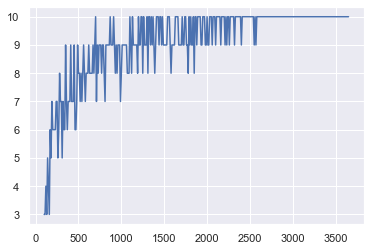

In [13]:
# one pass
result_list = []
sizes = np.arange(100, len(other_ips), 10)
for reservoir_size in sizes:
    results = reservoir_sampling(other_ips, reservoir_size)
    res = compute_reservoir_error(other_ips, results, 10)
    result_list.append(res)
    
plt.plot(sizes, result_list)
plt.show()